# Import Library

In [4]:
import os
import numpy as np
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [ ]:
import os

BASE_DIR = "DATA"
images_path = os.path.join(BASE_DIR, "Images")
captions_path = os.path.join(BASE_DIR, "captions.txt")

print("Images Path:", images_path)
print("Captions Path:", captions_path)


# Extract Features from the Image

In [5]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 1186s 2us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
features = {}
directory = os.path.join(BASE_DIR, 'Images')
for img_name in tqdm(os.listdir(directory)):
    
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    
    # convert image pixels to numpy array
    image = img_to_array(image)
    
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    
    # preprocess image for vgg
    image = preprocess_input(image)
    
    # extract features
    feature = model.predict(image, verbose=0)
    
    # get image ID
    image_id = img_name.split('.')[0]
    
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [ ]:
import pickle
import os

WORKING_DIR = "Processed_Feature"
os.makedirs(WORKING_DIR, exist_ok=True)  

file_path = os.path.join(WORKING_DIR, 'features.pkl')


with open(file_path, 'wb') as f:
    pickle.dump(features, f)

print(f"Features saved successfully at: {file_path}")

Features saved successfully at: Processed_Feature\features.pkl


In [16]:
with open(file_path, "rb") as f:
    features = pickle.load(f)

# Load Caption Data

In [17]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [ ]:
# create mapping of image to captions
mapping = {}

for line in tqdm(captions_doc.split('\n')):
    
    # split the line by comma(,)
    tokens = line.split(',')
    
    if len(line) < 2:
        continue
        
    image_id, caption = tokens[0], tokens[1:]
    
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    
    # convert caption list to string
    caption = " ".join(caption)
    
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
        
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [19]:
len(mapping)

8091

# Text Processing Data

In [ ]:
def clean(mapping):
    
    for key, captions in mapping.items():
        
        for i in range(len(captions)):
            
            caption = captions[i]
            
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
        
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [ ]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
clean(mapping)
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [23]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [24]:
len(all_captions)
all_captions[:5]
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8485

In [25]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

# Train Test Split & Model Building

In [26]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Embedding, add
from tensorflow.keras.models import Model

# Data Generator
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = [], [], []
    n = 0
    while True:
        for key in data_keys:
            n += 1
            captions = mapping[key]

            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)

            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                #Use tuple instead of list to avoid TypeError
                yield ((X1, X2), y)
                X1, X2, y = [], [], []
                n = 0

inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

#Train Model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    print(f"\nTraining Epoch {i+1}/{epochs}")
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

print("\n✅ Training Complete!")


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 35)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 35, 256)   │  2,172,160 │ input_layer_8[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 4096)      │          0 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 35, 256)   │          0 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, 35)        │          0 │ input_layer_8[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 256)       │  1,048,832 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 256)       │    525,312 │ dropout_7[0][0],  │
│                     │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 256)       │          0 │ dense_9[0][0],    │
│                     │                   │            │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 256)       │     65,792 │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 8485)      │  2,180,645 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,992,741 (22.86 MB)

 Trainable params: 5,992,741 (22.86 MB)

 Non-trainable params: 0 (0.00 B)


🧠 Training Epoch 1/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 409s 2s/step - loss: 5.1280

🧠 Training Epoch 2/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 544s 2s/step - loss: 3.9094

🧠 Training Epoch 3/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 530s 2s/step - loss: 3.5092

🧠 Training Epoch 4/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 513s 2s/step - loss: 3.2549

🧠 Training Epoch 5/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 560s 2s/step - loss: 3.0632

🧠 Training Epoch 6/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 534s 2s/step - loss: 2.9224

🧠 Training Epoch 7/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 576s 3s/step - loss: 2.8097

🧠 Training Epoch 8/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 570s 3s/step - loss: 2.7200

🧠 Training Epoch 9/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 540s 2s/step - loss: 2.6441

🧠 Training Epoch 10/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 581s 3s/step - loss: 2.5747

🧠 Training Epoch 11/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 577s 3s/step - loss: 2.5139

🧠 Training Epoch 12/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 551s 2s/step - loss: 2.4600

🧠 Training Epoch 13/20
227/227 ━━━━━

In [39]:
# save the model
model.save('best_model.h5')

# Generating Captions for images

In [40]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    
    in_text = 'startseq'
    
    for i in range(max_length):
        
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)

        if word is None:
            break

        in_text += " " + word
        if word == 'endseq':
            break
      
    return in_text

# Calculate Bleu Score

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    
    # append to the list
    actual.append(actual_captions)
    
    predicted.append(y_pred)
# calcuate BLEU score
print("BLEU: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU: 0.524214


In [43]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
    
    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('Actual')
    for caption in captions:
        print(caption)
        
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('      ')
    print(' Predicted ')
    print(y_pred)
    plt.imshow(image)

Actual
startseq four wheel drive car is navigating along rocky off road trail endseq
startseq jeep sidewalks on some rocks endseq
startseq red jeep hangs from the edge of rocky cliff as girl looks on endseq
startseq red truck is driving over rocky surface endseq
startseq woman stands next to red suv that has run off into ditch endseq
      
 Predicted 
startseq jeep sidewalks on rocky beach endseq


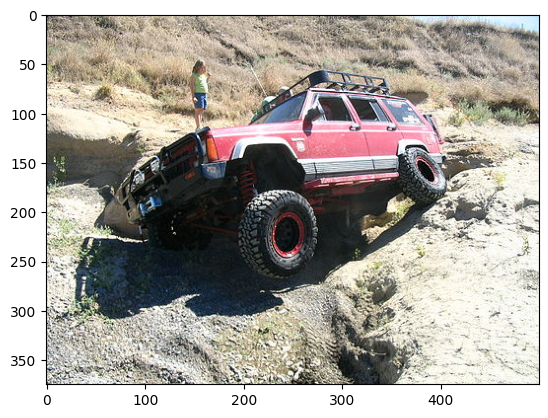

In [47]:
generate_caption('36422830_55c844bc2d.jpg')

Actual
startseq group of people on blue raft going down river endseq
startseq group of people paddle their blue inflatable raft down the rapids endseq
startseq group of people white water rafting in blue raft endseq
startseq several people are rafting down choppy river in rocky terrain endseq
startseq some people are riding raft down white water river endseq
      
 Predicted 
startseq two people are sitting on the edge of the river overlooked by boats endseq


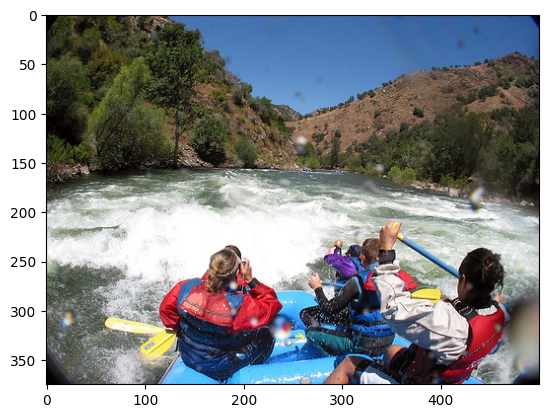

In [48]:
generate_caption('84713990_d3f3cef78b.jpg')